# Imports

In [1]:
import time
import csv
import os
import pandas as pd
from sklearn import preprocessing, model_selection, svm, linear_model, metrics
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import MeanShift
import numpy as np
from sklearn.exceptions import DataConversionWarning
import import_ipynb
import Modeling_Functions
import statsmodels.api as sm
import statsmodels.graphics.api as smg
from statsmodels.graphics.plot_grids import scatter_ellipse
import matplotlib.pyplot as plt
import seaborn as sns

importing Jupyter notebook from Modeling_Functions.ipynb


# Set Prediction Date

In [2]:
predictions_date = '2018-10-23'

# Creating Positional DataFrames

### Truncate NBAData After The Prediction Date
Remove all rows after the date for which we are predicting. Split size is the proportion of the proportion of the remaining data on which to predict

In [3]:
df = pd.read_csv('NBAData.csv')

#Sort by date
df = df.set_index('GID')
df = df.sort_index()
df = df.reset_index()

#Delete all rows after prediction date
df = df[df['Over/Under'] < 1000]
date_range = df.index[df['Date']==predictions_date]
start_range = date_range[0]
end_range = date_range[len(date_range)-1]
df = df.truncate(after = end_range)

### Drop Unnecessary Columns
Drop all columns that are not used to predict scores and save training data in df_orig

In [4]:
df.drop('Year',inplace=True, axis=1)
df.drop('Month',inplace=True, axis=1)
df.drop('Day',inplace=True, axis=1)
df.drop('Team',inplace=True, axis=1)
df.drop('Opponent',inplace=True, axis=1)
df.drop('Season',inplace=True, axis=1)
df.drop('Unnamed: 0',inplace=True, axis=1)
df.drop('Away',inplace=True, axis=1)
df = df.drop(['Value'],axis=1)
#'Avg PTS','Spread','Avg FG','Avg 3P','Avg FT','Avg TRB','Avg TOV','Avg STL','Avg BLK','Avg AST'

### Create Dummy Variables
Create and columns for a dummy variable for position. Then drop original columns

In [5]:
#df_dummy_opp = pd.get_dummies(df['Season+Opp'])
df_dummy_pos = pd.get_dummies(df['Position'])
df = pd.concat([df, df_dummy_pos], axis=1)
df.drop('Season+Opp',inplace=True, axis=1)
df.drop('Position',inplace=True, axis=1)

### Seperate Each Position into Its Own DataFrame for Modeling
Seperates each position, pg, sg, sf, pf, c, into its own dataframe and stores those dataframes in df_list

In [6]:
df_pg = df[df['PG'] == 1]
df_sg = df[df['SG'] == 1]
df_sf = df[df['SF'] == 1]
df_pf = df[df['PF'] == 1]
df_c = df[df['C'] == 1]

df_pg.drop(['SF','SG','PF','C','PG'],inplace=True, axis=1)
df_sg.drop(['SF','PG','PF','C','SG'],inplace=True, axis=1)
df_sf.drop(['PG','SG','PF','C','SF'],inplace=True, axis=1)
df_pf.drop(['SF','SG','PG','C','PF'],inplace=True, axis=1)
df_c.drop(['SF','SG','PF','PG','C'],inplace=True, axis=1)

df_pg = df_pg.set_index('GID').sort_index().reset_index()
df_sg = df_sg.set_index('GID').sort_index().reset_index()
df_sf = df_sf.set_index('GID').sort_index().reset_index()
df_pf = df_pf.set_index('GID').sort_index().reset_index()
df_c = df_c.set_index('GID').sort_index().reset_index()

df_pg.drop('GID',inplace=True,axis=1)
df_sg.drop('GID',inplace=True,axis=1)
df_sf.drop('GID',inplace=True,axis=1)
df_pf.drop('GID',inplace=True,axis=1)
df_c.drop('GID',inplace=True,axis=1)



df_list = [df_pg,df_sg,df_sf,df_pf,df_c]

/Users/ethanariowitsch/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Save Arrays for Test Data
Save Date, Salary, Projected Points, Position, Name columns for the test data that will later be added to predictions.csv

#### Find Index at Which to Split DataFrames

In [7]:
pg_test_num = Modeling_Functions.get_test_num(df_pg, predictions_date)
sg_test_num = Modeling_Functions.get_test_num(df_sg, predictions_date)
sf_test_num = Modeling_Functions.get_test_num(df_sf, predictions_date)
pf_test_num = Modeling_Functions.get_test_num(df_pf, predictions_date)
c_test_num = Modeling_Functions.get_test_num(df_c, predictions_date)

#### Save Arrays for Later Use

In [8]:
pg_date = np.array(df_pg['Date'])[-pg_test_num:]
pg_salary = np.array(df_pg['Salary'])[-pg_test_num:]
pg_proj_points = np.array(df_pg['Projected Points'])[-pg_test_num:]
pg_names_array = np.array(df_pg['Name'])[-pg_test_num:]
df_pg.drop('Date',inplace=True, axis=1)
df_pg.drop(['Name'],inplace=True, axis=1)

In [9]:
sg_date = np.array(df_sg['Date'])[-sg_test_num:]
sg_salary = np.array(df_sg['Salary'])[-sg_test_num:]
sg_proj_points = np.array(df_sg['Projected Points'])[-sg_test_num:]
sg_names_array = np.array(df_sg['Name'])[-sg_test_num:]
df_sg.drop('Date',inplace=True, axis=1)
df_sg.drop(['Name'],inplace=True, axis=1)

In [10]:
pf_date = np.array(df_pf['Date'])[-pf_test_num:]
pf_salary = np.array(df_pf['Salary'])[-pf_test_num:]
pf_proj_points = np.array(df_pf['Projected Points'])[-pf_test_num:]
pf_names_array = np.array(df_pf['Name'])[-pf_test_num:]
df_pf.drop('Date',inplace=True, axis=1)
df_pf.drop(['Name'],inplace=True, axis=1)

In [11]:
sf_date = np.array(df_sf['Date'])[-sf_test_num:]
sf_salary = np.array(df_sf['Salary'])[-sf_test_num:]
sf_proj_points = np.array(df_sf['Projected Points'])[-sf_test_num:]
sf_names_array = np.array(df_sf['Name'])[-sf_test_num:]
df_sf.drop('Date',inplace=True, axis=1)
df_sf.drop(['Name'],inplace=True, axis=1)

In [12]:
c_date = np.array(df_c['Date'])[-c_test_num:]
c_salary = np.array(df_c['Salary'])[-c_test_num:]
c_proj_points = np.array(df_c['Projected Points'])[-c_test_num:]
c_names_array = np.array(df_c['Name'])[-c_test_num:]
df_c.drop('Date',inplace=True, axis=1)
df_c.drop(['Name'],inplace=True, axis=1)

# Data Visualization

### Graphing Variable Correlation to Points for Each Position
Graphs Projected Points, Salary, Over/Under, Spread, Avg MP, and Avg DK Points against actual points to get a look at their value as a predictor

/Users/ethanariowitsch/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


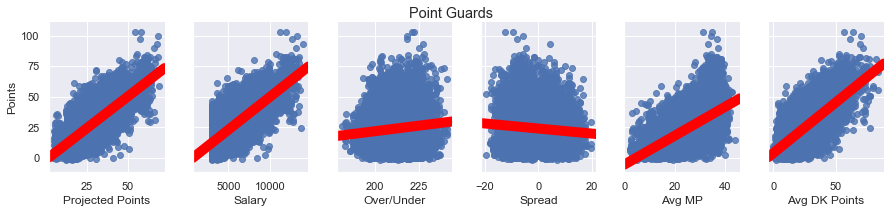

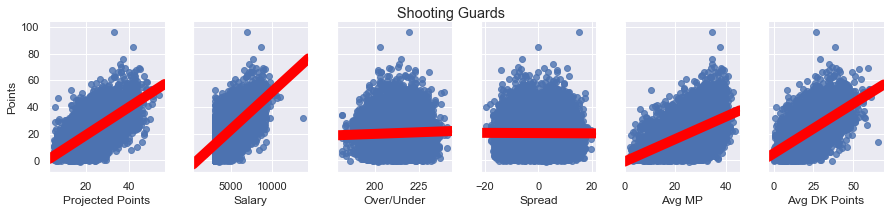

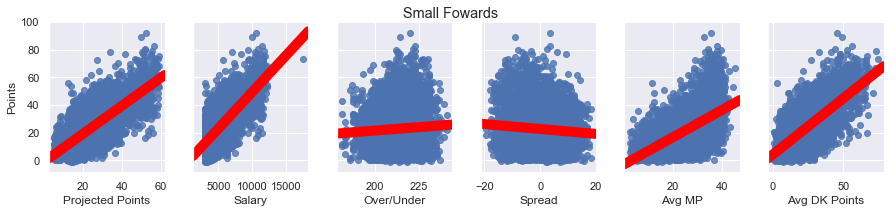

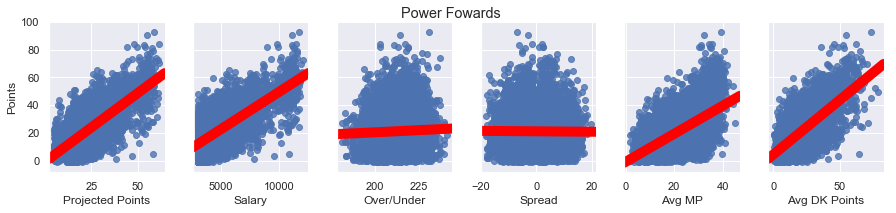

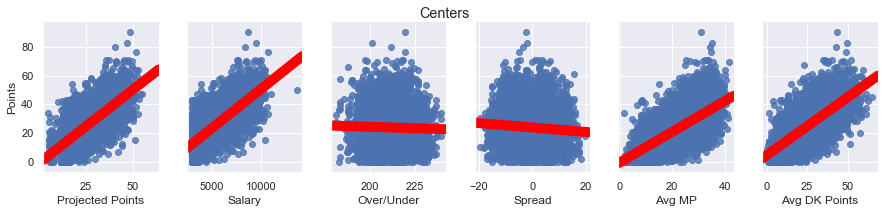

In [13]:
sns.set()
i = 0
df_names = ['Point Guards', "Shooting Guards", "Small Fowards", "Power Fowards", "Centers"]
for df in df_list:
    g = sns.pairplot(df, kind='reg',x_vars=['Projected Points', "Salary", "Over/Under", 
                                            "Spread", "Avg MP", "Avg DK Points"], 
                 y_vars='Points', size=3, aspect=0.7, plot_kws={'line_kws':{'linewidth':10,'color':'red'}})
    g.fig.suptitle(df_names[i])
    
    i=i+1

### DvP Correlation with Points at Each Postion
Uses seaborn regplot() to graph the best fit line between the mean player performances at every opponent DvP for each position

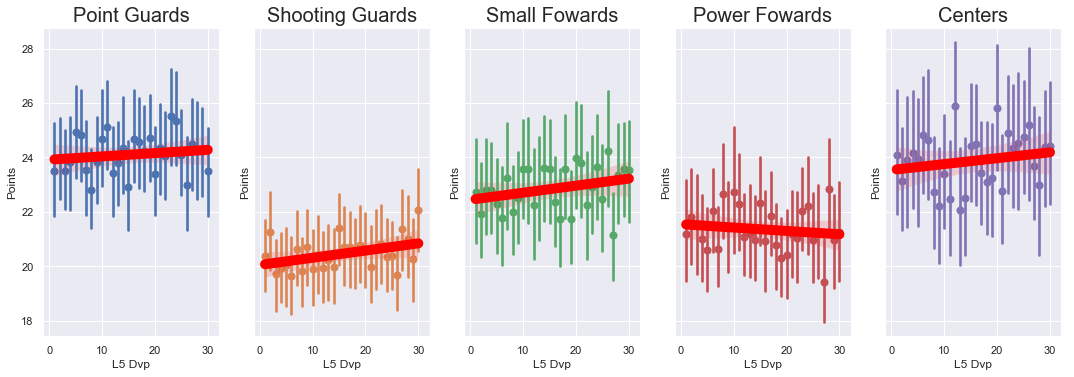

In [14]:
sns.set()
i=0
fig, ax = plt.subplots(1, 5, sharey='row', figsize=(15,5))
plt.tight_layout()
for df in df_list:
    sns.set()
    sns.regplot('L5 Dvp', 'Points', data=df, fit_reg=True, x_estimator=np.mean, truncate=True,
                line_kws={'linewidth':10,'color':'red'}, 
                ax=ax[i]).set_title(df_names[i], fontsize = 20)    
    i=i+1

### Looking at Coefficient Correlation Matrix
Shows a table of correlation coefficients between each possible variable pair for each individual position and lastly for all positions

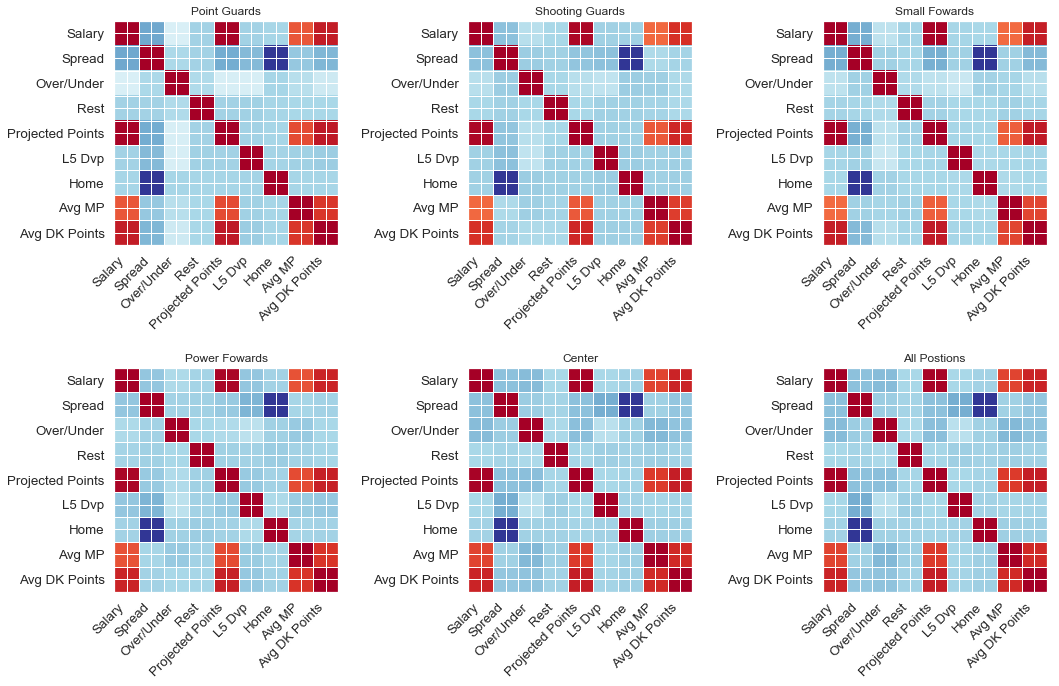

In [15]:
df_pg_no_points = df_pg.drop(["Points"],1)
df_sg_no_points = df_sg.drop(["Points"],1)
df_pf_no_points = df_pf.drop(["Points"],1)
df_sf_no_points = df_sf.drop(["Points"],1)
df_c_no_points = df_c.drop(["Points"],1)
df_no_points = df.drop(["Points"],1)

pg_corr_matrix = df_pg_no_points.corr()
sg_corr_matrix = df_sg_no_points.corr()
sf_corr_matrix = df_sf_no_points.corr()
pf_corr_matrix = df_pf_no_points.corr()
c_corr_matrix = df_c_no_points.corr()
df_corr_matrix = df_no_points.corr()


fig, ax = plt.subplots(2, 3, figsize=(15,10))
plt.rcParams.update({'font.size': 16})

smg.plot_corr(pg_corr_matrix, xnames=df_pg_no_points.columns, ax=ax[0][0], 
              title="Point Guards")
smg.plot_corr(sg_corr_matrix, xnames=df_sg_no_points.columns, ax=ax[0][1], 
              title="Shooting Guards")
smg.plot_corr(sf_corr_matrix, xnames=df_sf_no_points.columns, ax=ax[0][2], 
              title="Small Fowards")
smg.plot_corr(pf_corr_matrix, xnames=df_pf_no_points.columns, ax=ax[1][0], 
              title="Power Fowards")
smg.plot_corr(c_corr_matrix, xnames=df_c_no_points.columns, ax=ax[1][1], 
              title="Center")
smg.plot_corr(df_corr_matrix, xnames=df_no_points.columns, ax=ax[1][2], 
              title="All Postions")
plt.show()

# Modeling

### Seperate Into Train and Test Sets
Creates train and test sets for each position

In [16]:
pg_training_data = np.array(df_pg.drop(['Points'],1))[:-pg_test_num]
pg_training_answers = np.array(df_pg['Points'])[:-pg_test_num]
pg_test_data = np.array(df_pg.drop(['Points'],1))[-pg_test_num:]
pg_test_answers = np.array(df_pg['Points'])[-pg_test_num:]

sg_training_data = np.array(df_sg.drop(['Points'],1))[:-sg_test_num]
sg_training_answers = np.array(df_sg['Points'])[:-sg_test_num]
sg_test_data = np.array(df_sg.drop(['Points'],1))[-sg_test_num:]
sg_test_answers = np.array(df_sg['Points'])[-sg_test_num:]

sf_training_data = np.array(df_sf.drop(['Points'],1))[:-sf_test_num]
sf_training_answers = np.array(df_sf['Points'])[:-sf_test_num]
sf_test_data = np.array(df_sf.drop(['Points'],1))[-sf_test_num:]
sf_test_answers = np.array(df_sf['Points'])[-sf_test_num:]

pf_training_data = np.array(df_pf.drop(['Points'],1))[:-pf_test_num]
pf_training_answers = np.array(df_pf['Points'])[:-pf_test_num]
pf_test_data = np.array(df_pf.drop(['Points'],1))[-pf_test_num:]
pf_test_answers = np.array(df_pf['Points'])[-pf_test_num:]

c_training_data = np.array(df_c.drop(['Points'],1))[:-c_test_num]
c_training_answers = np.array(df_c['Points'])[:-c_test_num]
c_test_data = np.array(df_c.drop(['Points'],1))[-c_test_num:]
c_test_answers = np.array(df_c['Points'])[-c_test_num:]

### Linear Regression Vs Random Forest Vs Expert Predictions

In [17]:
pg_lin_pred, pg_for_pred = Modeling_Functions.model_analysis(pg_training_data, pg_training_answers, pg_test_data, pg_test_answers, pg_proj_points, "PG")
sg_lin_pred, sg_for_pred = Modeling_Functions.model_analysis(sg_training_data, sg_training_answers, sg_test_data, sg_test_answers, sg_proj_points, "SG")
sf_lin_pred, sf_for_pred = Modeling_Functions.model_analysis(sf_training_data, sf_training_answers, sf_test_data, sf_test_answers, sf_proj_points, "SF")
pf_lin_pred, pf_for_pred = Modeling_Functions.model_analysis(pf_training_data, pf_training_answers, pf_test_data, pf_test_answers, pf_proj_points, "PF")
c_lin_pred, c_for_pred = Modeling_Functions.model_analysis(c_training_data, c_training_answers, c_test_data, c_test_answers, c_proj_points, "C")

i = i+1
col_labels = ['Position','Score', 'Regression Type']
pos_labels = ['PG', 'SG', 'SF', 'PF', 'C']
r2_lin = [metrics.r2_score(pg_test_answers, pg_lin_pred), metrics.r2_score(sg_test_answers, sg_lin_pred),
         metrics.r2_score(sf_test_answers, sf_lin_pred), metrics.r2_score(pf_test_answers, pf_lin_pred), 
         metrics.r2_score(c_test_answers, c_lin_pred)]
r2_for = [metrics.r2_score(pg_test_answers, pg_for_pred), metrics.r2_score(sg_test_answers, sg_for_pred),
         metrics.r2_score(sf_test_answers, sf_for_pred), metrics.r2_score(pf_test_answers, pf_for_pred), 
         metrics.r2_score(c_test_answers, c_for_pred)]
r2_proj = [metrics.r2_score(pg_test_answers, pg_proj_points), metrics.r2_score(sg_test_answers, sg_proj_points),
         metrics.r2_score(sf_test_answers, sf_proj_points), metrics.r2_score(pf_test_answers, pf_proj_points), 
         metrics.r2_score(c_test_answers, c_proj_points)]

mae_lin = [metrics.mean_absolute_error(pg_test_answers, pg_lin_pred), metrics.mean_absolute_error(sg_test_answers, sg_lin_pred),
         metrics.mean_absolute_error(sf_test_answers, sf_lin_pred), metrics.mean_absolute_error(pf_test_answers, pf_lin_pred), 
         metrics.mean_absolute_error(c_test_answers, c_lin_pred)]
mae_for = [metrics.mean_absolute_error(pg_test_answers, pg_for_pred), metrics.mean_absolute_error(sg_test_answers, sg_for_pred),
         metrics.mean_absolute_error(sf_test_answers, sf_for_pred), metrics.mean_absolute_error(pf_test_answers, pf_for_pred), 
         metrics.mean_absolute_error(c_test_answers, c_for_pred)]
mae_proj = [metrics.mean_absolute_error(pg_test_answers, pg_proj_points), metrics.mean_absolute_error(sg_test_answers, sg_proj_points),
         metrics.mean_absolute_error(sf_test_answers, sf_proj_points), metrics.mean_absolute_error(pf_test_answers, pf_proj_points), 
         metrics.mean_absolute_error(c_test_answers, c_proj_points)]

### Combine Postion Specific DataFrames
Combining the dataframes for each position and calculating the mean absolute error and r2 for both our modeled predictions and expert predictions

In [18]:
results = pd.DataFrame()

results['Name']= np.concatenate([pg_names_array,sg_names_array,sf_names_array,pf_names_array,c_names_array])
results['Position']= np.concatenate([np.full(len(pg_lin_pred), "PG"), np.full(len(sg_lin_pred), "SG"),
                                    np.full(len(sf_lin_pred), "SF"), np.full(len(pf_lin_pred), "PF"),
                                    np.full(len(c_lin_pred), "C")])
results['Salary']= np.concatenate([pg_salary, sg_salary, sf_salary, pf_salary,c_salary])
results['Projected Points']= np.concatenate([pg_proj_points, sg_proj_points, sf_proj_points,
                                             pf_proj_points, c_proj_points])
results['Predicted Points']= np.concatenate([pg_lin_pred, sg_lin_pred, sf_lin_pred,
                                             pf_lin_pred, c_lin_pred]).round(1)
results['Day']= np.concatenate([pg_date, sg_date, sf_date, pf_date,c_date])
results['Points']= np.concatenate([pg_test_answers, sg_test_answers, sf_test_answers,
                                             pf_test_answers, c_test_answers])

results.to_csv('Predictions.csv')